## Import

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import spacy


from tqdm import tqdm

from millenlp.preprocessing import PreProc
from millenlp.embeddings import FastTextVec, TfidfVec
from millenlp.state_models.shallow_model import ShallowModel

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.manifold import TSNE
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from graphviz import Digraph

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric
from gensim.corpora import WikiCorpus
from gensim.models import FastText

/opt/conda/envs/nlp/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## function definitions

In [2]:
def ranking_by_label_prediction(data_set,model,label):
    data_set['Prediction'] = data_set['iteration'].apply(lambda x : model._classifier.predict(model._vectorizer.transform([model.preprocessing(x)]))[0])
    data_set[model._classifier.classes_] = pd.DataFrame(data_set['iteration'].apply(lambda x : model._classifier.predict_proba(model._vectorizer.transform([model.preprocessing(x)]))[0]).values.tolist(), 
                                                                                index= data_set.index)
    return data_set.sort_values([label], ascending = [0])

def vocabulary(model, label_to_sort):
    
    if 'FastText' is model._vectorizer._embedding.__class__.__name__:
        classes = model._classifier.classes_
        word_dict = list(model._vectorizer._embedding.wv.vocab.keys())

        features_words = pd.DataFrame(model._vectorizer.transform(word_dict), 
                                      columns = list(range(model._vectorizer._num_features)))
        features_words = features_words.astype(float)

        features_ranked = pd.DataFrame(word_dict, columns = ['feature'])
        for i, label in enumerate(classes):
            topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
            ranking_dim = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
            ranking_dim['feature'] = list(range(model._vectorizer._num_features))
            ranking_dim = ranking_dim.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
            ranking_dim = ranking_dim[ranking_dim[model._classifier.classes_].idxmax(axis=1)==label]

            feature_weight = pd.DataFrame()
            features_words_filtered = features_words[ranking_dim.feature.tolist()]
            feature_weight[label] = np.dot(features_words_filtered.values,
                                           ranking_dim[label_to_sort].values) / features_words_filtered.shape[1]
            features_ranked = pd.concat([features_ranked,feature_weight], axis = 1)

        features_ranked = features_ranked.sort_values(by=[label_to_sort], ascending = False)
        
    elif 'TfidfVectorizer' is model._vectorizer._embedding.__class__.__name__:
        
        topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
#         topics = model._classifier.classes_.tolist()
        features_ranked = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
        features_ranked['feature'] = model._vectorizer._embedding.get_feature_names()
        features_ranked = features_ranked.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
        
    return features_ranked

def node_coef(data_set,coef_features,msg_col,label_col,feature,per_class):
    if per_class:
        data_set = data_set[data_set.label == label_col]
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    if feature in coef_features.feature.values:
        coef = coef_features[coef_features.feature.isin([feature])][label_col].values[0]
    else:
        coef = 'Not in Dict'
    feature_info = pd.DataFrame(np.array([[feature,count_feature,round(coef,2)]]),
                                      columns = ['feature','counts','coef'])
    return feature_info 

def prob_around_word(data_set,coef_features,regex,msg_col,label_col, feature, per_class):
    
    if per_class:
        data_set = data_set[data_set.label == label_col]
        
    regex = regex.replace('{}',feature)
    look_around = data_set[msg_col].str.extract(regex, expand=False)
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    
    if isinstance(look_around, pd.DataFrame):
        look_around = look_around.iloc[:,-1]
        
    look_around = look_around.dropna().value_counts().to_frame().reset_index()  
    look_around.columns = ['feature','counts']
    look_around['probability'] = np.divide(look_around.counts.values,np.sum(look_around.counts.values))*100
    look_around['coef'] = [round(coef_features[coef_features.feature.isin([word])][label_col].values[0],2)
                           if word in coef_features.feature.values else 'Not in Dict' 
                           for word in look_around.feature.values]
    return look_around

def left_parents(data_set, child, graph, dot):
    for parent in data_set.feature.values:
        data = data_set[data_set.feature==parent]
        if parent in list(graph.keys()):
            graph[parent][child] = (data.probability.values[0],
                                    data.counts.values[0],
                                    data.coef.values[0])
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
        else:
            graph[parent] = {child: (data.probability.values[0],
                                     data.counts.values[0],
                                     data.coef.values[0])}
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
    return graph, dot

def right_child(data_set, parent, graph,dot):
    if parent in list(graph.keys()):
        graph[parent] = {**graph[parent],**dict(zip(data_set.feature.values,
                                                   zip(data_set.probability.values,
                                                       data_set.counts.values,
                                                      data_set.coef.values)))}
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
        
    else:
        graph[parent] = dict(zip(data_set.feature.values,
                               zip(data_set.probability.values,
                                   data_set.counts.values,
                                   data_set.coef.values)))
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
    return graph, dot

def set_graph_atr(dot, coef):
    if isinstance(coef,str):
        dot.attr('node',style='filled', color='lightgrey')
    else:
        if coef > 0:
            dot.attr('node',style='filled', color='green')
        elif coef <= 0:
            dot.attr('node', style='filled', color='red')
    return dot

def create_adjacency_graph(data_set,model,label,num_features,per_class,levels):

    coef_vocab = vocabulary(model,label)
    features = coef_vocab.feature.iloc[:num_features+1].values.tolist()
    feature = features[num_features]
    
    check_around = ['(\w+(?=(?:\s(?:\w+\s){level}){}))',
                    '(({}\s)(\s*(\w+)){0,level})']
    
    graph = {}
    dot = Digraph(comment='Data Feature Probability Relationship')
    feature_data = node_coef(data_set,coef_vocab,'iteration',label,feature,per_class)
    dot.attr('node',style='filled', color='blue')
    dot.node(feature_data.feature.values[0],'{} \n Count = {} \n Coef = {}'.format(feature_data.feature.values[0],
                                                                                   feature_data.counts.values[0],
                                                                                   feature_data.coef.values[0]))
    for side in range(levels):
        where_to_check = check_around[side].replace('level',str(side))
        for level in range(levels):
            words_lvl1 = prob_around_word(data_set,
                                          coef_vocab,
                                          where_to_check,
                                          'iteration',
                                          label,
                                          feature,
                                          per_class).query('probability>5')
            if not side and level == 0:
                graph, dot = left_parents(words_lvl1, feature, graph, dot)
            elif not side and level == 1:
                for word in words_lvl1.feature.values:
                    
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = left_parents(words_lvl2, word, graph, dot)
            elif side and level == 0:   
                graph, dot = right_child(words_lvl1, feature, graph, dot)
            elif side and level == 1:
                for word in words_lvl1.feature.values:
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = right_child(words_lvl2, word, graph, dot)
    return dot

def elbow_plot(features, clusters2test):
    
    clust = []
    final_distance = []
    l = features.shape[0]
    for cluster in range(2, clusters2test):
        clust = KMeans(cluster).fit_predict(features)
        distances_per_cl = []
        cluster_list = clust.tolist()
        weight = [cluster_list.count(cluster_num)/l for cluster_num in range(0, cluster)]
        for clu in range(cluster):
            centroide = features[np.where(clust == clu)[0],:].mean(axis = 0).reshape(1,-1)
            euc_distance = euclidean_distances(features[np.where(clust == clu)[0],:], centroide)
            distances_per_cl.append(euc_distance.mean())
            
        final_distance.append((np.array(distances_per_cl)@ weight)/len(distances_per_cl))
    
    plt.plot(list(range(2, clusters2test)),final_distance)
    
    return final_distance                                
                                
def plot_word_cloud(data, cluster):
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white",width=700, height=400).generate(data)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("wordclouds/{}.png".format(cluster))


In [3]:
# Options to display all the information inside the row
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
tqdm.pandas()
# Class PreProc
p = PreProc()
p._remove_digits = True
p._stop_pos_words = []
p._remove_names = False

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
data_base = pd.read_csv('/home/JhonChavez/clustering_codensa/data_emergencia.csv')
print (data_base.shape)

(113788, 9)


In [5]:
data_base[0:10]

product            sessionId  \
0  /voicebot_codensa_b2c  2-1578082323.601250   
1  /voicebot_codensa_b2c  1-1578082408.737052   
2  /voicebot_codensa_b2c  2-1578082580.601341   
3  /voicebot_codensa_b2c  2-1578082699.601374   
4  /voicebot_codensa_b2c  2-1578082796.601402   
5  /voicebot_codensa_b2c  2-1578082849.601415   
6  /voicebot_codensa_b2c  1-1578082867.737243   
7  /voicebot_codensa_b2c  2-1578082931.601438   
8  /voicebot_codensa_b2c  1-1578082985.737287   
9  /voicebot_codensa_b2c  1-1578083095.737341   

                                                                                                                                                                                                                                _text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   
5  emergencias  43  2020-01-03 15:22:05.147743-05:00  Emergencias  0.428879   
6  emergencias  47  2020-01-03 15:22:30.122180-05:00  Emergencias  0.393107   
7  emergencias  52  2020-01-03 15:23:18.158533-05:00  Emergencias  0.397747   
8  emergencias  58  2020-01-03 15:24:22.121047-05:00  Emergencias  0.106807   
9  emergencias  76  2020-01-03 15:26:19.747221-05:00  Emergencias  0.682655   

         clase  
0  Emergencias  
1  Emerge

In [8]:
session = []
text = ''
df = pd.DataFrame()
for idx, data in enumerate(data_base['sessionId']):
    text = ''
    text += ' ' + str(data_base['_text'][data_base['sessionId'] == data])#.iloc[y])
    df = df.append({'Text' : text, 'Session': data}, ignore_index=True)
    if idx > 2000:
        break
df = df.drop_duplicates()

In [7]:
df[:10]

Session  \
0  2-1578082323.601250   
1  1-1578082408.737052   
2  2-1578082580.601341   
3  2-1578082699.601374   
4  2-1578082796.601402   
5  2-1578082849.601415   
6  1-1578082867.737243   
7  2-1578082931.601438   
8  1-1578082985.737287   
9  1-1578083095.737341   

                                                                                                                                                                                                                                                                   Text  
0   0    no hay servicio\nName: _text, dtype: object                                                                                                                                                                                                                     
1   1    escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor\nName: _text, dtype: object                                                                                                                       
2   2    estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas\nName: _text, dtype: object                                                                                                             
3   3    y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no\nName: _text, dtype: object                                                                                                                                    
4   4    hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos\nName: _text, dtype: object                                                                                                                     
5   5    no hay energia\nName: _text, dtype: object                                                                                                                                                                                                                      
6   6    problemas del servicio\nName: _text, dtype: object                                                                                                                                                                                                              
7   7    corte de luz\nName: _text, dtype: object                                                                                                                                                                                                                        
8   8    lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso\nName: _text, dtype: object  
9   9    falla en el servicio\nName: _text, dtype: object

In [159]:
df['Text'] = df['Text'].str.replace('\n', '')
df['Text'] = df['Text'].str.replace('Name:', '')
df['Text'] = df['Text'].str.replace('_text,', '')
df['Text'] = df['Text'].str.replace('dtype:', '')
df['Text'] = df['Text'].str.replace('object', '')
df['Text'] = df['Text'].str.replace('\d+', '')

In [160]:
df['Text'] = df['Text'].str.replace('\nName: _text, dtype: object', '')
df['Text'] = df['Text'].str.replace('\d+', '')

In [161]:
df

Session  \
0     2-1578082323.601250   
1     1-1578082408.737052   
2     2-1578082580.601341   
3     2-1578082699.601374   
4     2-1578082796.601402   
5     2-1578082849.601415   
6     1-1578082867.737243   
7     2-1578082931.601438   
8     1-1578082985.737287   
9     1-1578083095.737341   
10    1-1578083117.737354   
11    1-1578083186.737395   
12    2-1578083255.601533   
13    2-1578083304.601545   
14    1-1578083322.737449   
15    2-1578083543.601622   
16    2-1578083570.601631   
17    1-1578083598.737579   
18    2-1578083632.601656   
19    2-1578083666.601670   
20    2-1578083782.601713   
21    2-1578083808.601723   
22    2-1578083817.601728   
23    1-1578083797.737657   
24    2-1578083847.601740   
25    1-1578083856.737680   
26    2-1578083895.601757   
27    2-1578083911.601765   
28    1-1578083947.737719   
29    1-1578083943.737714   
30    1-1578083962.737730   
31    2-1578084004.601801   
32    1-1578083988.737743   
33    1-1578084069.737765   
34    1-1578084090.737773   
35    2-1578084181.601872   
36    1-1578084241.737828   
37    2-1578084347.601940   
38    1-1578084346.737869   
39    2-1578084370.601950   
40    1-1578084419.737893   
41    1-1578084436.737901   
42    2-1578084473.601982   
43    1-1578084479.737920   
44    1-1578084549.737950   
45    2-1578084641.602043   
46    1-1578084778.738050   
47    1-1578084760.738038   
48    2-1578084829.602112   
49    2-1578084833.602116   
50    1-1578084842.738065   
51    2-1578084862.602121   
52    1-1578084901.738094   
53    2-1578085174.602240   
54    2-1578085274.602275   
55    2-1578085265.602273   
56    1-1578085312.738263   
57    1-1578085342.738281   
58    1-1578085387.738305   
59    1-1578085399.738311   
60    2-1578085515.602361   
61    1-1578085656.738431   
62    2-1578085665.602409   
63    1-1578085751.738468   
64    2-1578085812.602449   
65    2-1578085851.602462   
66    2-1578085869.602468   
67    2-1578085887.602474   
68    2-1578085910.602483   
69    2-1578085927.602490   
70    2-1578085938.602492   
71    1-1578085935.738537   
72    1-1578085979.738545   
73    1-1578086053.738577   
74    1-1578086035.738574   
75    1-1578086172.738633   
76    1-1578086184.738639   
77    2-1578086255.602596   
78    2-1578086330.602616   
79    1-1578086329.738716   
80    2-1578086343.602619   
81    2-1578086470.602664   
82    2-1578086471.602667   
83    2-1578086926.602820   
84    1-1578086994.739020   
85    1-1578087018.739033   
86    2-1578087177.602904   
87    2-1578087383.602967   
88    2-1578087498.603006   
89    2-1578087717.603073   
90    2-1578088058.603169   
91    2-1578088115.603190   
92    1-1578088167.739476   
93    2-1578088233.603218   
94    1-1578088246.739502   
95    2-1578088215.603209   
96    1-1578088253.739506   
97    1-1578088273.739518   
98    2-1578088286.603235   
99    2-1578088298.603238   
100   2-1578088333.603244   
101   2-1578088450.603273   
102   1-1578088445.739570   
103   2-1578088600.603316   
104   1-1578088651.739640   
105   1-1578088670.739645   
106   2-1578088703.603354   
107   1-1578088751.739667   
108   1-1578088733.739663   
109   1-1578088791.739680   
110   2-1578088965.603428   
111   2-1578089030.603452   
112   1-1578089020.739765   
113   2-1578089045.603456   
114   2-1578089266.603555   
115   2-1578089360.603596   
116   2-1578089432.603623   
117   1-1578089588.739914   
118   1-1578089612.739923   
119   2-1578089790.603700   
120   1-1578089788.739998   
121   1-1578089836.740022   
122   2-1578089826.603707   
123   1-1578089846.740028   
124   1-1578089919.740059   
125   2-1578089939.603747   
126   2-1578089991.603765   
127   2-1578090052.603781   
128   2-1578090120.603801   
129   2-1578090155.603815   
130   2-1578090161.603818   
131   1-1578090233.740181   
132   1-1578090268.740189   
133   1-1578090337.740207   
134   1-1578090334.740205   
135   1-1578090376.740215   
136   1-1578090412.740221   
137   1-15780905

In [6]:
data_base_enh = data_base#[:2000]

In [7]:
data_base_enh['lemma'] = data_base_enh['_text'].progress_apply(lambda x : p.apply(x))

100%|██████████| 113788/113788 [42:29<00:00, 44.63it/s] 


In [13]:
data_base_enh[:5]

product            sessionId  \
0  /voicebot_codensa_b2c  2-1578082323.601250   
1  /voicebot_codensa_b2c  1-1578082408.737052   
2  /voicebot_codensa_b2c  2-1578082580.601341   
3  /voicebot_codensa_b2c  2-1578082699.601374   
4  /voicebot_codensa_b2c  2-1578082796.601402   

                                                                                                                     _text  \
0  no hay servicio                                                                                                           
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor             
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas   
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                          
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos           

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   

         clase  \
0  Emergencias   
1  Emergencias   
2  Emergencias   
3  Emergencias   
4  Emergencias   

                                                                                                                  lemma  
0  no haber servicio                                                                                                     
1  escorpion corte de energia desde las de la manana y ser las de la manana solucionar el problema por                   
2  estar llamar la vereda campo municipal caparrapi desde el lunes estar sin luz y no ser posible que los guardar linea  
3  y casi todos los dia estar sin luz en el primero todos ser hora y ahora otra vez no                                   
4  haber muchos cortes de energia constantes bajones de luz porque ya me bloquear porque me esta danando los aparatos

In [8]:
data_base_enh.shape

(113788, 10)

In [9]:
filename = 'chat_lemma.csv'

In [10]:
data_base_enh.to_csv(filename)

In [11]:
cluster_data = pd.read_csv(filename)

In [12]:
cluster_data.shape

(113788, 11)

In [14]:
cluster_data[:5]

Unnamed: 0                product            sessionId  \
0  0           /voicebot_codensa_b2c  2-1578082323.601250   
1  1           /voicebot_codensa_b2c  1-1578082408.737052   
2  2           /voicebot_codensa_b2c  2-1578082580.601341   
3  3           /voicebot_codensa_b2c  2-1578082699.601374   
4  4           /voicebot_codensa_b2c  2-1578082796.601402   

                                                                                                                     _text  \
0  no hay servicio                                                                                                           
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor             
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas   
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                          
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos           

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   

         clase  \
0  Emergencias   
1  Emergencias   
2  Emergencias   
3  Emergencias   
4  Emergencias   

                                                                                                                  lemma  
0  no haber servicio                                                                                                     
1  escorpion corte de energia desde las de la manana y ser las de la manana solucionar el problema por                   
2  estar llamar la vereda campo municipal caparrapi desde el lunes estar sin luz y no ser posible que los guardar linea  
3  y casi todos los dia estar sin luz en el primero todos ser hora y ahora otra vez no                                   
4  haber muchos cortes de energia constantes bajones de luz porque ya me bloquear porque me esta danando los aparatos

In [15]:
fasttext = FastTextVec()
fasttext.fit(cluster_data['lemma'].apply(lambda x: str(x)))

Number of features: 6281



In [16]:
features = fasttext.transform(cluster_data['lemma'])
features.shape

(113788, 300)

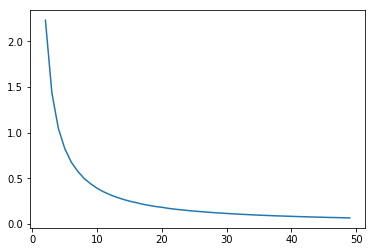

In [18]:
distances = elbow_plot(features, clusters2test = 50)

In [24]:
len(distances)

48

In [26]:
second_diff = np.diff(np.diff(distances))

In [88]:
second_diff

array([ 4.09428711e-01,  1.64826992e-01,  7.53199504e-02,  4.69659798e-02,
        2.10758797e-02,  2.19419874e-02,  8.52185821e-03,  1.02782418e-02,
        6.45173136e-03,  5.66509143e-03,  3.31513832e-03,  3.29721121e-03,
        4.17263906e-03, -1.72664196e-03,  4.57408441e-03,  3.19754434e-04,
        3.94412516e-03, -2.90786680e-03,  2.63317577e-03,  1.51852011e-03,
        7.46172349e-05,  9.55851734e-04,  5.70290708e-04,  2.25955497e-04,
        2.28892154e-04,  7.65645672e-04, -1.77369989e-04,  9.71083399e-04,
       -4.35291453e-04,  9.25033504e-04, -4.69833374e-04,  3.02465487e-04,
        8.70842254e-04, -5.35303201e-04,  5.68780780e-04,  4.01974823e-04,
       -3.93846175e-04,  2.10789130e-04,  2.04466856e-04, -1.83053727e-04,
        6.33381360e-04, -1.91109920e-04, -1.96856034e-04,  7.64856306e-04,
       -5.98277903e-04,  2.55036274e-04])

In [32]:
if second_diff[0] > 0:
    m_sign = 1
else:
    m_sign = 0
cluster_index = 0
for idx, elem in enumerate(second_diff):
    if (elem > 0 and m_sign == 0) or (elem < 0 and m_sign == 1):
        cluster_index = idx
        break
print(cluster_index)

13


In [33]:
Kmeans = KMeans(n_clusters = cluster_index).fit(features)

In [34]:
cluster_number = pd.DataFrame(Kmeans.predict(features), columns = ['ClusterNumber'])
cluster_number

ClusterNumber
0       2            
1       9            
2       11           
3       5            
4       5            
...    ..            
113783  0            
113784  0            
113785  2            
113786  11           
113787  11           

[113788 rows x 1 columns]

In [35]:
type(cluster_number['ClusterNumber'].tolist()[0])

int

In [36]:
cluster_data['ClusterNumber'] = cluster_number['ClusterNumber'].tolist()

In [37]:
cluster_data[:10]

Unnamed: 0                product            sessionId  \
0  0           /voicebot_codensa_b2c  2-1578082323.601250   
1  1           /voicebot_codensa_b2c  1-1578082408.737052   
2  2           /voicebot_codensa_b2c  2-1578082580.601341   
3  3           /voicebot_codensa_b2c  2-1578082699.601374   
4  4           /voicebot_codensa_b2c  2-1578082796.601402   
5  5           /voicebot_codensa_b2c  2-1578082849.601415   
6  6           /voicebot_codensa_b2c  1-1578082867.737243   
7  7           /voicebot_codensa_b2c  2-1578082931.601438   
8  8           /voicebot_codensa_b2c  1-1578082985.737287   
9  9           /voicebot_codensa_b2c  1-1578083095.737341   

                                                                                                                                                                                                                                _text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   
5  emergencias  43  2020-01-03 15:22:05.147743-05:00  Emergencias  0.428879   
6  emergencias  47  2020-01-03 15:22:30.122180-05:00  Emergencias  0.393107   
7  emergencias  52  2020-01-03 15:23:18.158533-05:00  Emergencias  0.397747   
8  emergencias  58  2020-01-03 15:24:22.121047-05:00  Em

In [43]:
filename_cluster = 'chat_lemma_cluster.csv'

In [44]:
cluster_data.to_csv(filename_cluster)

In [39]:
cluster_data['ClusterNumber'].value_counts().to_frame()

ClusterNumber
5   30443        
11  22127        
1   18023        
2   9969         
6   8822         
9   6700         
4   5603         
10  3755         
0   2475         
3   2243         
12  1893         
8   1435         
7   300

In [62]:
cluster_to_train = cluster_data[['_text', 'lemma', 'ClusterNumber']].rename(columns = {'lemma' : 'iteration', 'ClusterNumber' : 'label'})

In [63]:
cluster_data.shape

(113788, 12)

In [57]:
cluster_to_train.shape

(113788, 3)

In [58]:
cluster_data[:10]

Unnamed: 0                product            sessionId  \
0  0           /voicebot_codensa_b2c  2-1578082323.601250   
1  1           /voicebot_codensa_b2c  1-1578082408.737052   
2  2           /voicebot_codensa_b2c  2-1578082580.601341   
3  3           /voicebot_codensa_b2c  2-1578082699.601374   
4  4           /voicebot_codensa_b2c  2-1578082796.601402   
5  5           /voicebot_codensa_b2c  2-1578082849.601415   
6  6           /voicebot_codensa_b2c  1-1578082867.737243   
7  7           /voicebot_codensa_b2c  2-1578082931.601438   
8  8           /voicebot_codensa_b2c  1-1578082985.737287   
9  9           /voicebot_codensa_b2c  1-1578083095.737341   

                                                                                                                                                                                                                                _text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   
5  emergencias  43  2020-01-03 15:22:05.147743-05:00  Emergencias  0.428879   
6  emergencias  47  2020-01-03 15:22:30.122180-05:00  Emergencias  0.393107   
7  emergencias  52  2020-01-03 15:23:18.158533-05:00  Emergencias  0.397747   
8  emergencias  58  2020-01-03 15:24:22.121047-05:00  Em

In [59]:
cluster_to_train[:10]

_text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

                                                                                                                                                                                                                        iteration  \
0  no haber servicio                                                                                                                                                                                                                
1  escorpion corte de energia desde las de la manana y ser las de la manana solucionar el problema por                                                                                                                              
2  estar llamar la vereda campo municipal caparrapi desde el lunes estar sin luz y no ser posible que los guardar linea                                                                                                             
3  y casi todos los dia estar sin luz en el primero todos ser hora y ahora otra vez no                                                                                                                                              
4  haber muchos cortes de energia constantes bajones de luz porque ya me bloquear porque me esta danando los aparatos                                                                                                               
5  no haber energia                                                                                                                                                                                                                 
6  problema del servicio                                 

In [60]:
cluster_to_train.shape

(113788, 3)

In [66]:
cluster_to_train.label = cluster_to_train.label.apply(lambda x: str(x))
cluster_to_train = cluster_to_train.dropna()
cluster_to_train.shape

(113744, 3)

In [46]:
cluster_to_train[:10]

_text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

                                                                                                                                                                                                                        iteration  \
0  no haber servicio                                                                                                                                                                                                                
1  escorpion corte de energia desde las de la manana y ser las de la manana solucionar el problema por                                                                                                                              
2  estar llamar la vereda campo municipal caparrapi desde el lunes estar sin luz y no ser posible que los guardar linea                                                                                                             
3  y casi todos los dia estar sin luz en el primero todos ser hora y ahora otra vez no                                                                                                                                              
4  haber muchos cortes de energia constantes bajones de luz porque ya me bloquear porque me esta danando los aparatos                                                                                                               
5  no haber energia                                                                                                                                                                                                                 
6  problema del servicio                                 

In [47]:
Tfidf = TfidfVec()
Tfidf._embedding = TfidfVectorizer(ngram_range=(1, 4),
                                   norm='l2',
                                   min_df=10,
                                   max_df=0.5,          
                                   tokenizer=None,
                                   strip_accents=None,
                                   lowercase=False)
clasifier = ShallowModel('tfidf')
clasifier._vectorizer = Tfidf
clasifier._preprocessing = None
# clasifier.fit(cluster_to_train)

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



SPLIT

Size of training set:     79620          
Size of validation set:   17062          
Size of test set:         17062          

TRAINING RESULTS


Accuracy:
0.88
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1736
           1       0.86      0.86      0.86     12585
          10       0.85      0.98      0.91      2654
          11       0.93      0.83      0.88     15468
          12       0.83      1.00      0.90      1314
           2       0.88      0.95      0.92      6999
           3       0.89      0.99      0.94      1528
           4       0.90      0.94      0.92      3964
           5       0.94      0.82      0.87     21288
           6       0.86      0.95      0.90      6196
           7       0.60      1.00      0.75       218
           8       0.69      0.99      0.82      1011
           9       0.77      0.95      0.85      4659

    accuracy                           0.88     79620
   macro avg       

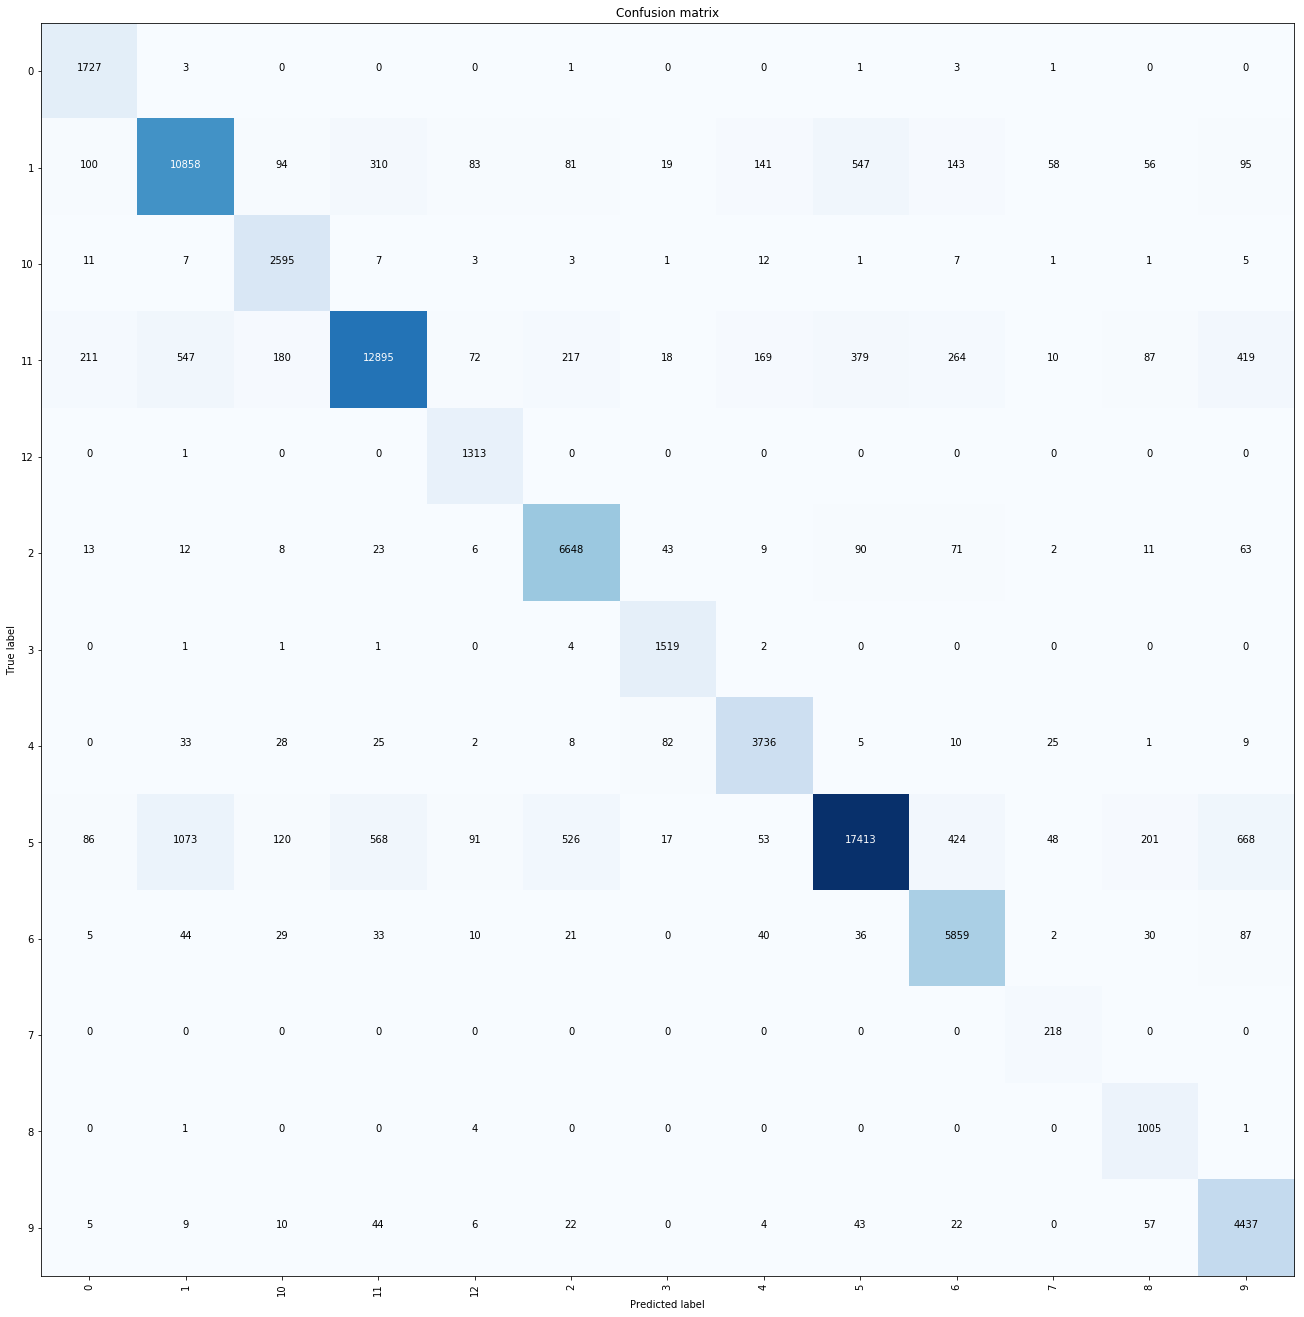


TESTING RESULTS


Accuracy:
0.85
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       389
           1       0.80      0.82      0.81      2692
          10       0.82      0.94      0.88       564
          11       0.90      0.79      0.85      3395
          12       0.79      0.98      0.87       286
           2       0.87      0.93      0.90      1508
           3       0.88      0.97      0.92       362
           4       0.86      0.91      0.89       821
           5       0.91      0.79      0.84      4472
           6       0.84      0.92      0.88      1316
           7       0.57      1.00      0.73        39
           8       0.63      0.95      0.76       210
           9       0.72      0.89      0.80      1008

    accuracy                           0.85     17062
   macro avg       0.80      0.91      0.84     17062
weighted avg       0.86      0.85      0.85     17062



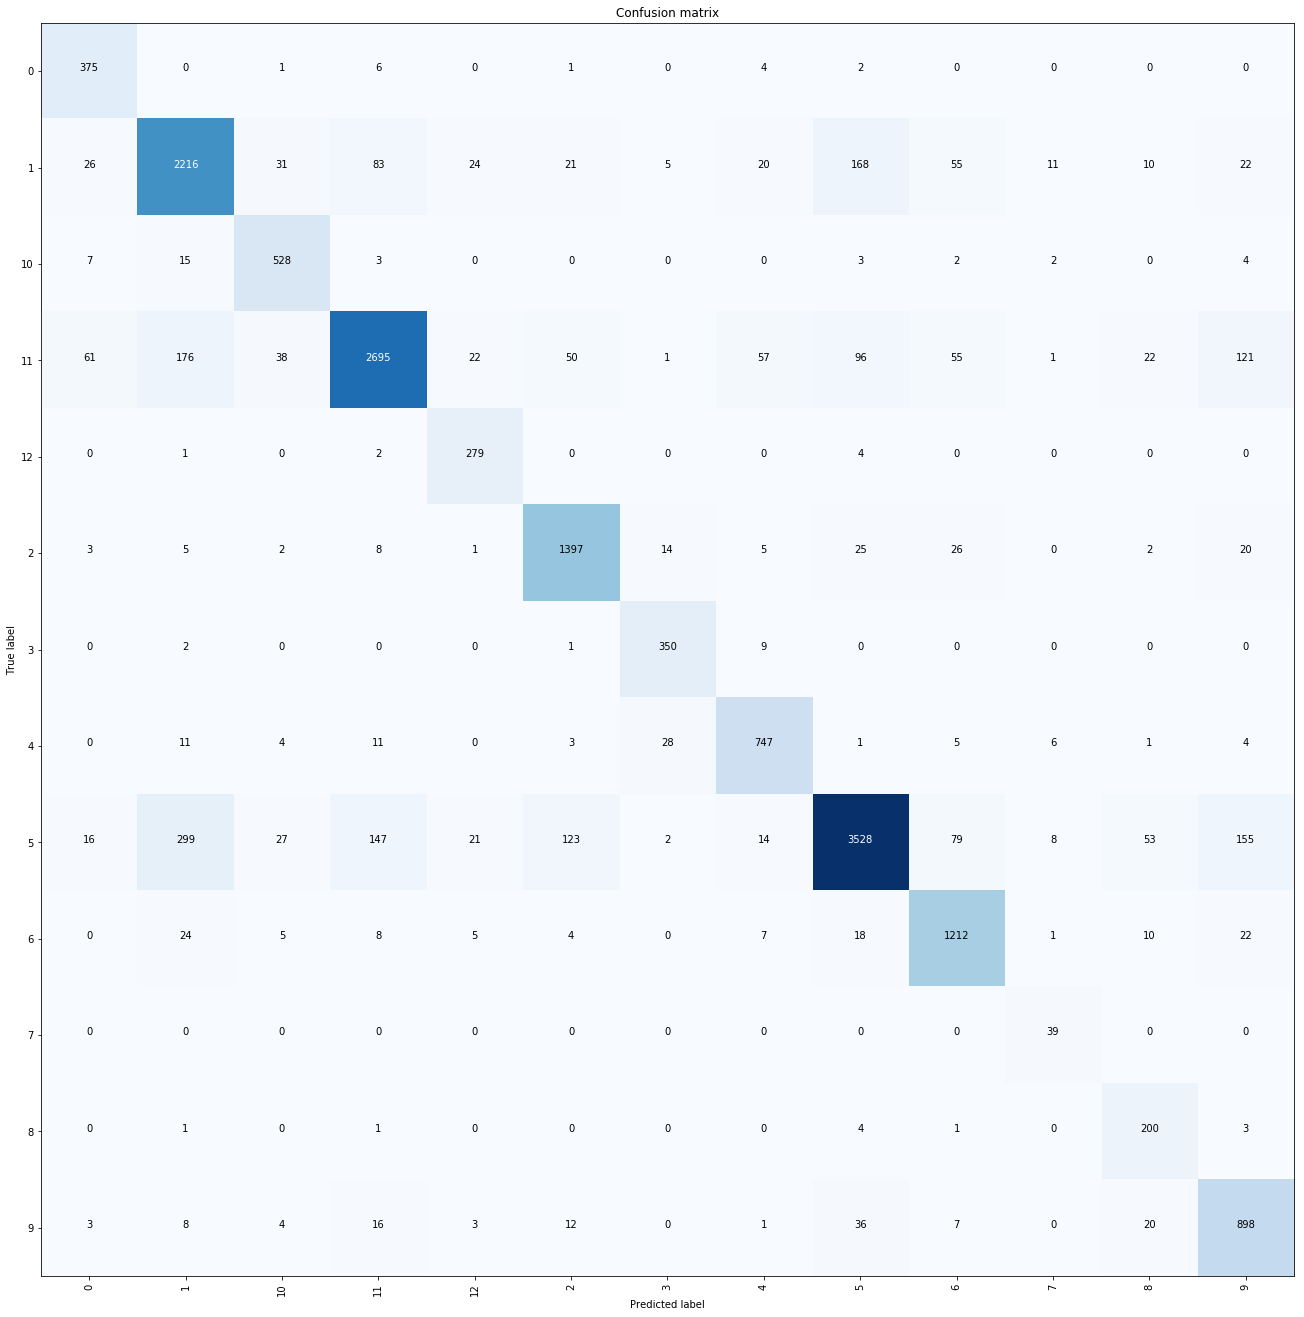

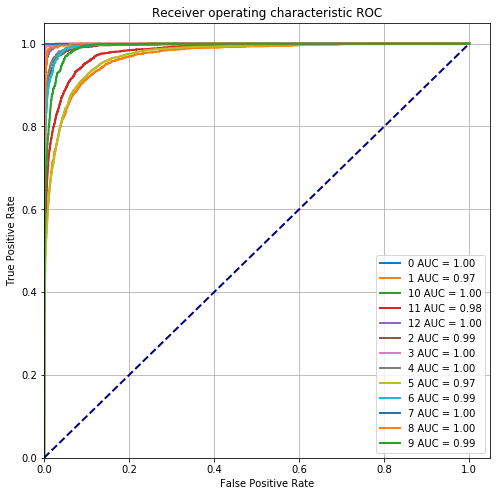

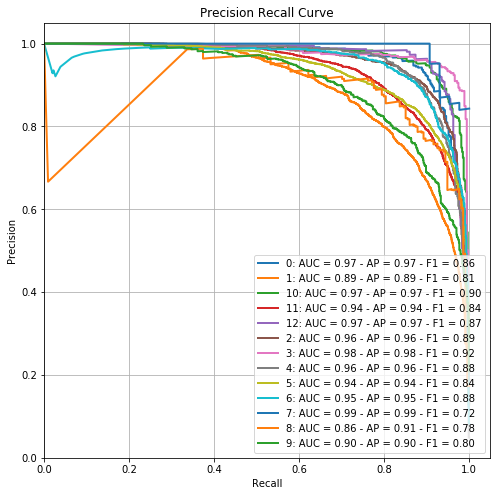


VALIDATION RESULTS

Threshold
[0.11, 0.22, 0.08, 0.17, 0.04, 0.18, 0.2, 0.07, 0.18, 0.14, 0.6, 0.27, 0.17]


class  false positive rate  true positive rate
0   0     0.014122             0.991429          
1   1     0.093741             0.910051          
2   10    0.017973             0.994413          
3   11    0.078457             0.936335          
4   12    0.026239             1.000000          
5   2     0.032436             0.970588          
6   3     0.004668             0.994334          
7   4     0.035151             0.981663          
8   5     0.108571             0.932949          
9   6     0.039487             0.977863          
10  7     0.000470             1.000000          
11  8     0.008250             0.985981          
12  9     0.050097             0.969990


TESTING RESULTS



class  false positive rate  true positive rate
0   0     0.002099             0.850900          
1   1     0.003410             0.481426          
2   10    0.003213             0.849291          
3   11    0.002634             0.534315          
4   12    0.002265             0.961538          
5   2     0.004372             0.822944          
6   3     0.000419             0.812155          
7   4     0.002955             0.834348          
8   5     0.004686             0.529964          
9   6     0.004001             0.816109          
10  7     0.000940             0.974359          
11  8     0.002492             0.871429          
12  9     0.005419             0.661706

In [49]:
clasifier.fit(cluster_to_train)

In [51]:
cluster_to_train[:10]

_text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

                                                                                                                                                                                                                        iteration  \
0  no haber servicio                                                                                                                                                                                                                
1  escorpion corte de energia desde las de la manana y ser las de la manana solucionar el problema por                                                                                                                              
2  estar llamar la vereda campo municipal caparrapi desde el lunes estar sin luz y no ser posible que los guardar linea                                                                                                             
3  y casi todos los dia estar sin luz en el primero todos ser hora y ahora otra vez no                                                                                                                                              
4  haber muchos cortes de energia constantes bajones de luz porque ya me bloquear porque me esta danando los aparatos                                                                                                               
5  no haber energia                                                                                                                                                                                                                 
6  problema del servicio                                 

In [67]:
cluster_to_train.shape

(113744, 3)

In [72]:
type(cluster_to_train.label[0])

str

In [74]:
data_tmp = cluster_to_train.label == str(2)

In [75]:
data_tmp[:10]

0    True 
1    False
2    False
3    False
4    False
5    False
6    True 
7    False
8    False
9    False
Name: label, dtype: bool

In [77]:
i_tmp = 2
for review in cluster_to_train[cluster_to_train.label == str(i_tmp)].iteration.tolist():
    print(review)
    break

no haber servicio


Cluster 0


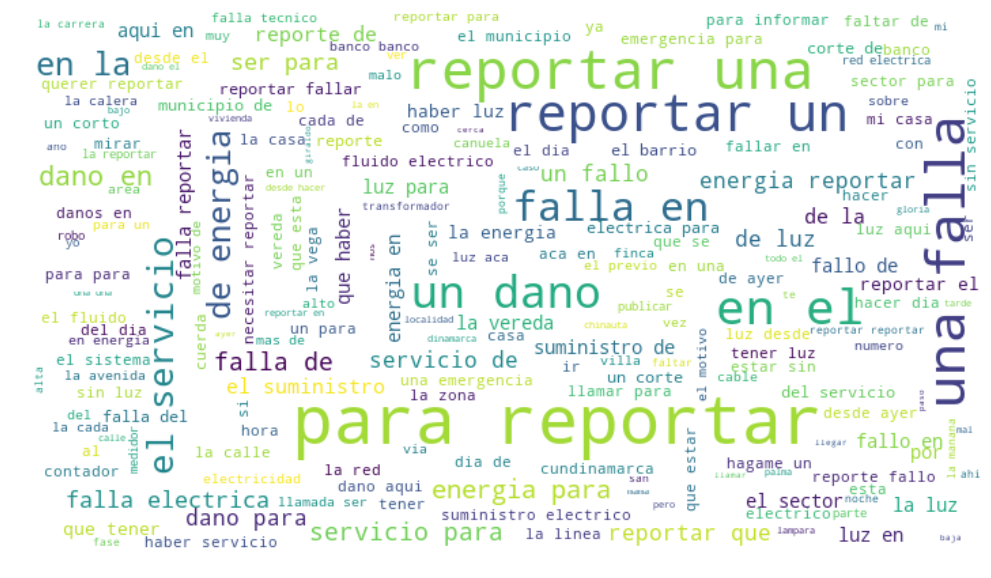

Cluster 1


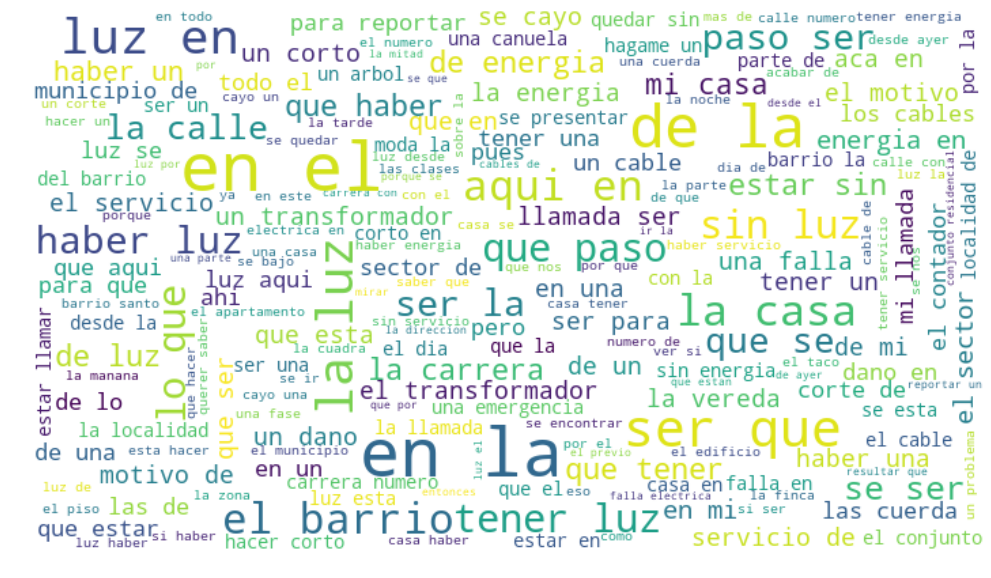

Cluster 2


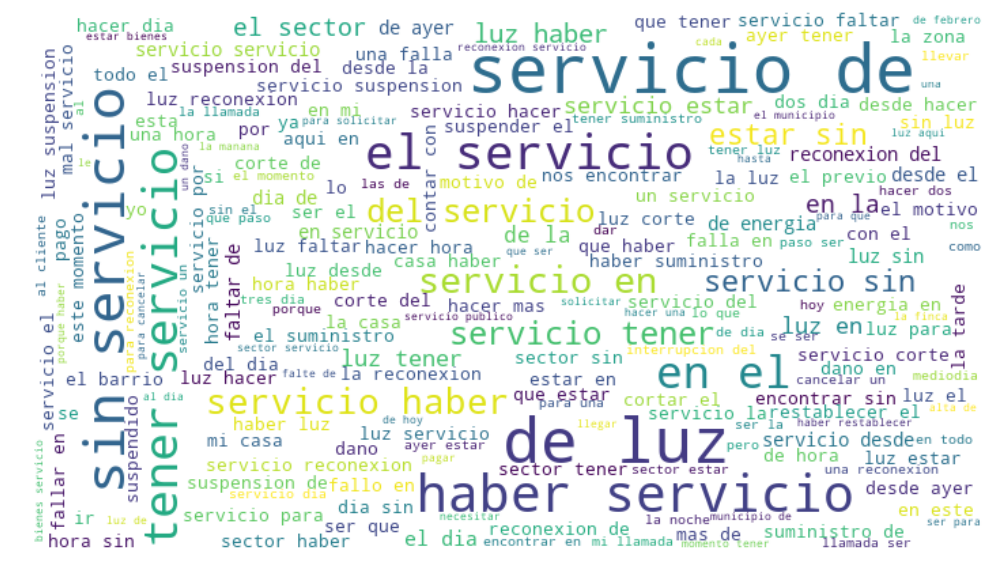

Cluster 3


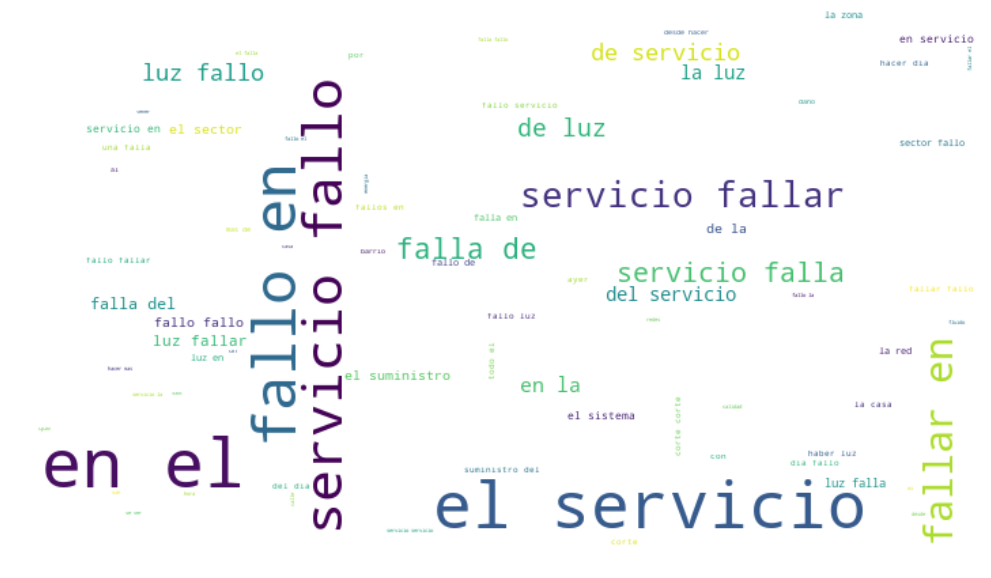

Cluster 4


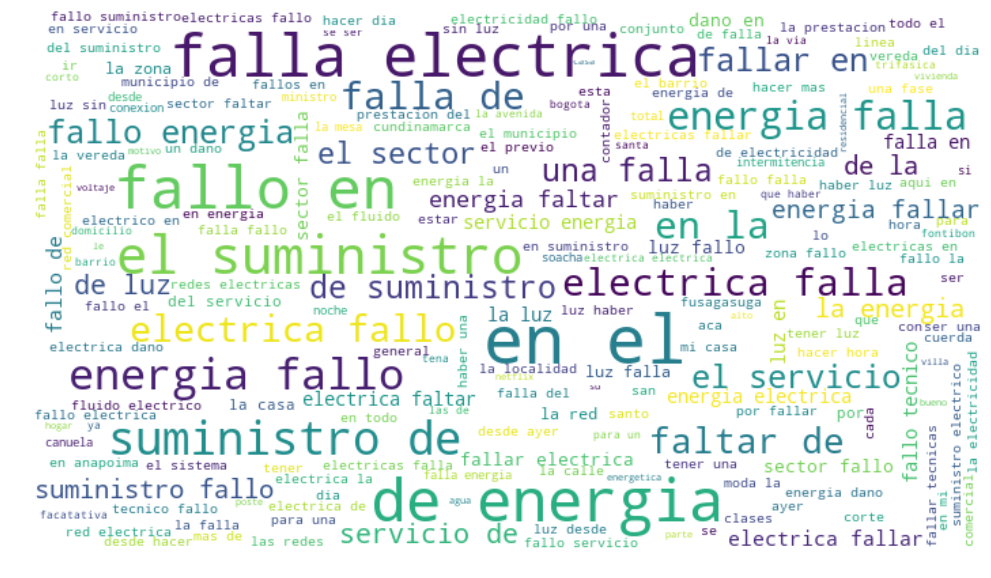

Cluster 5


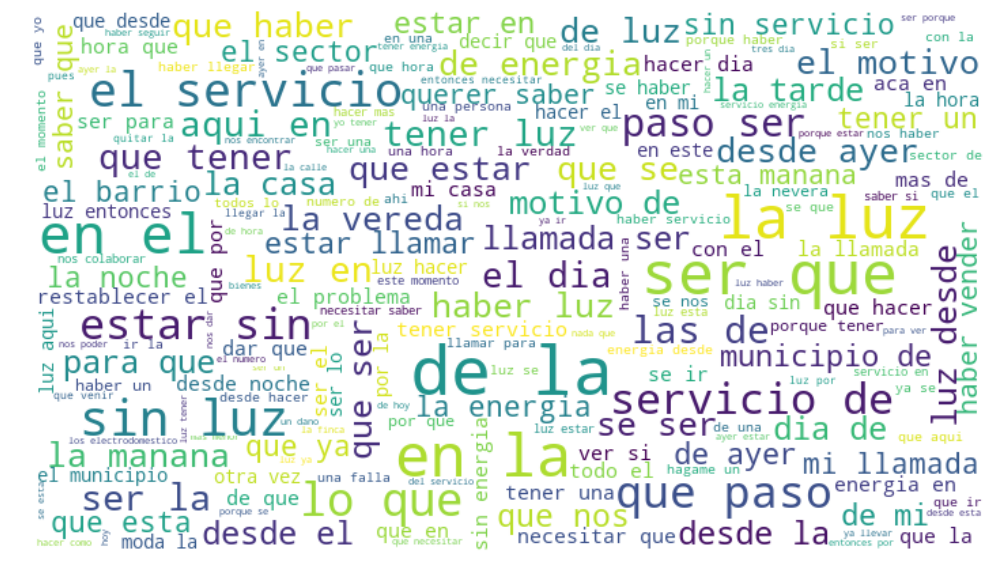

Cluster 6


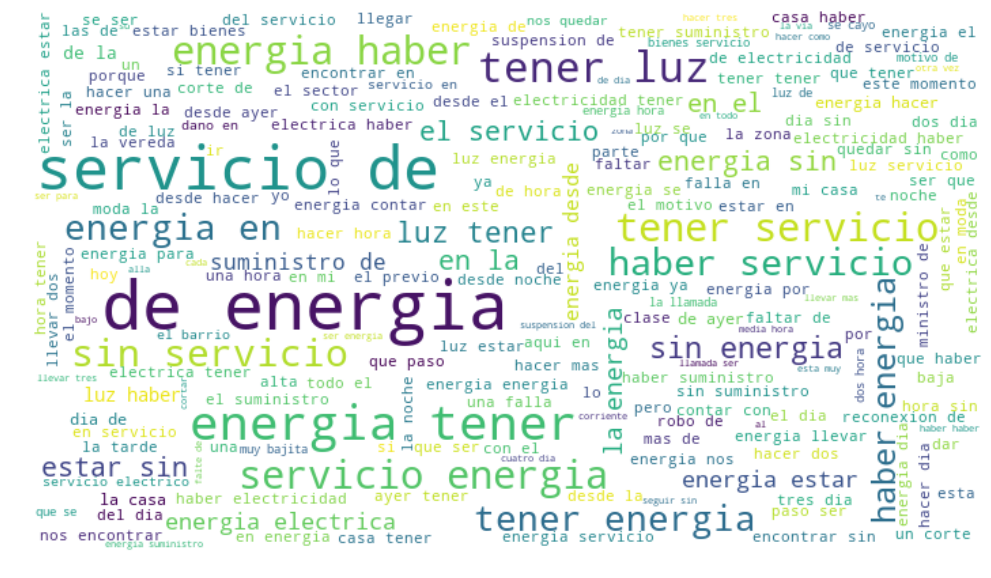

Cluster 7


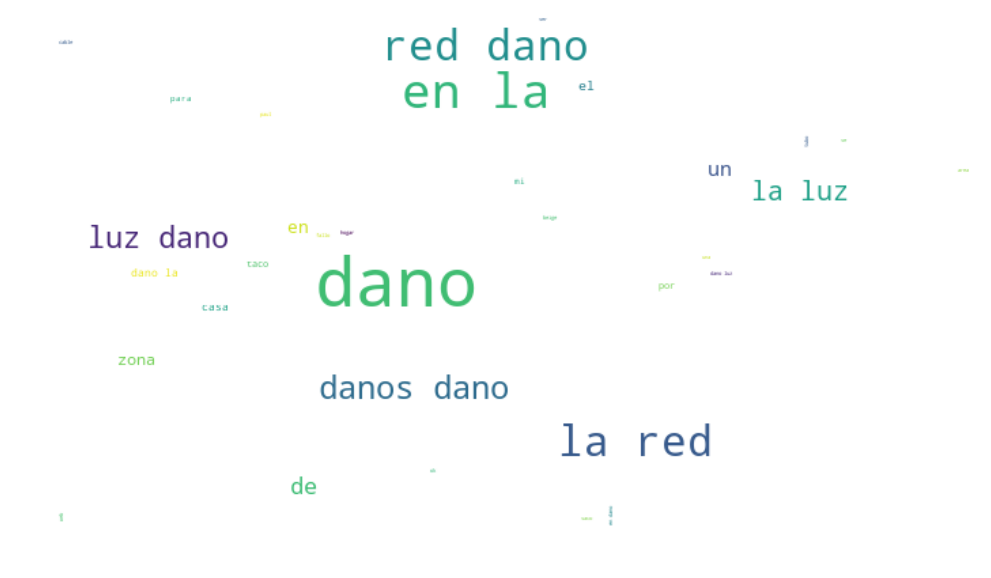

Cluster 8


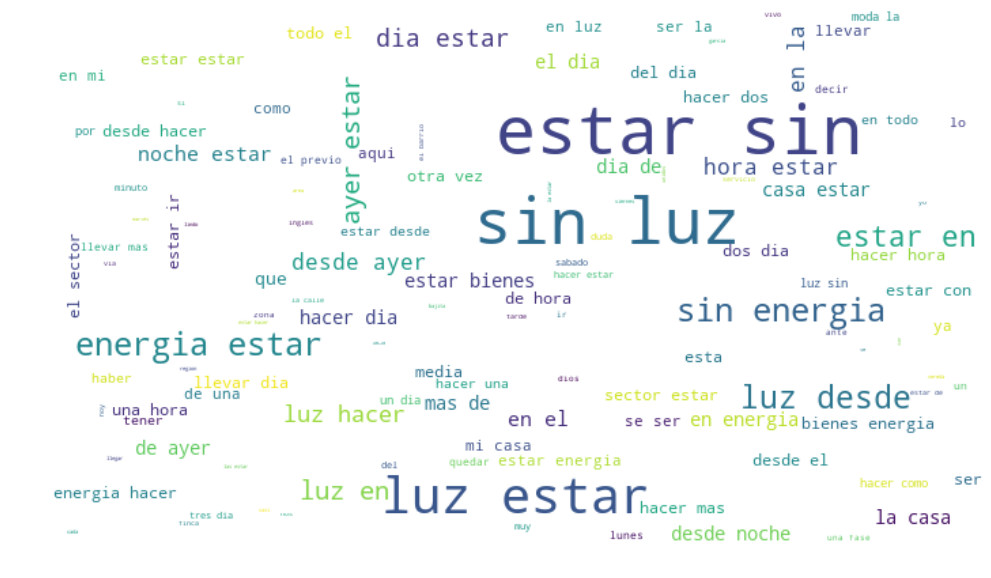

Cluster 9


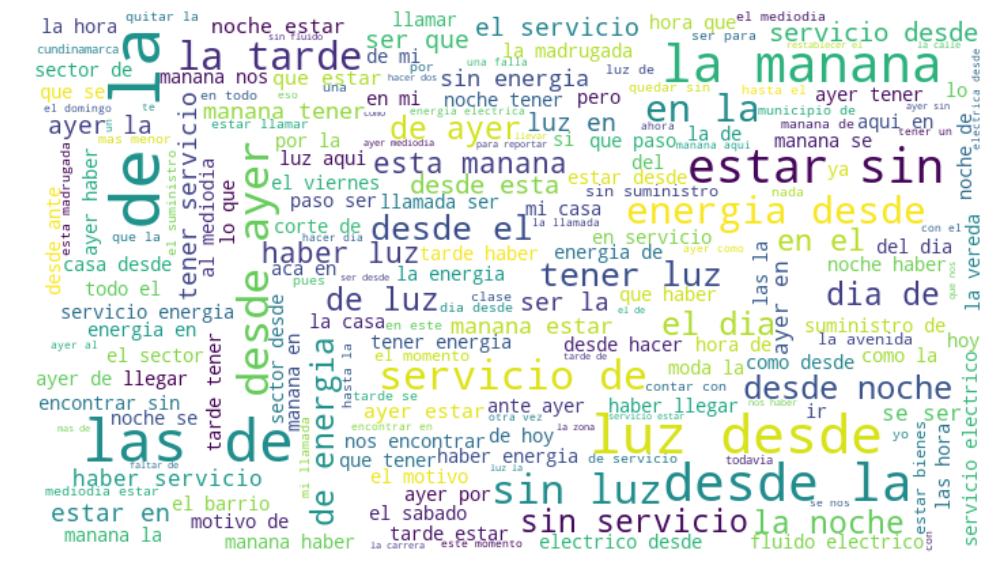

Cluster 10


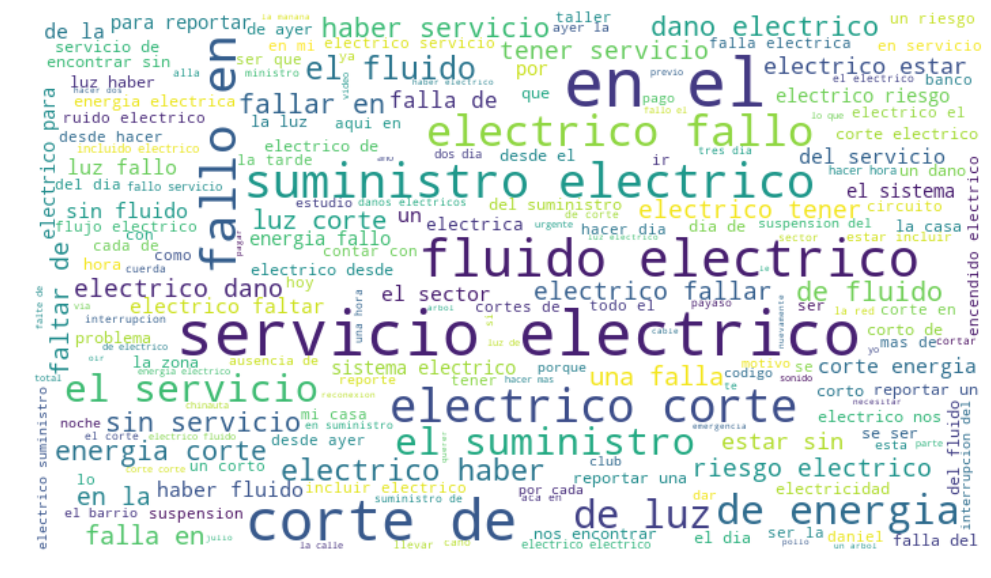

Cluster 11


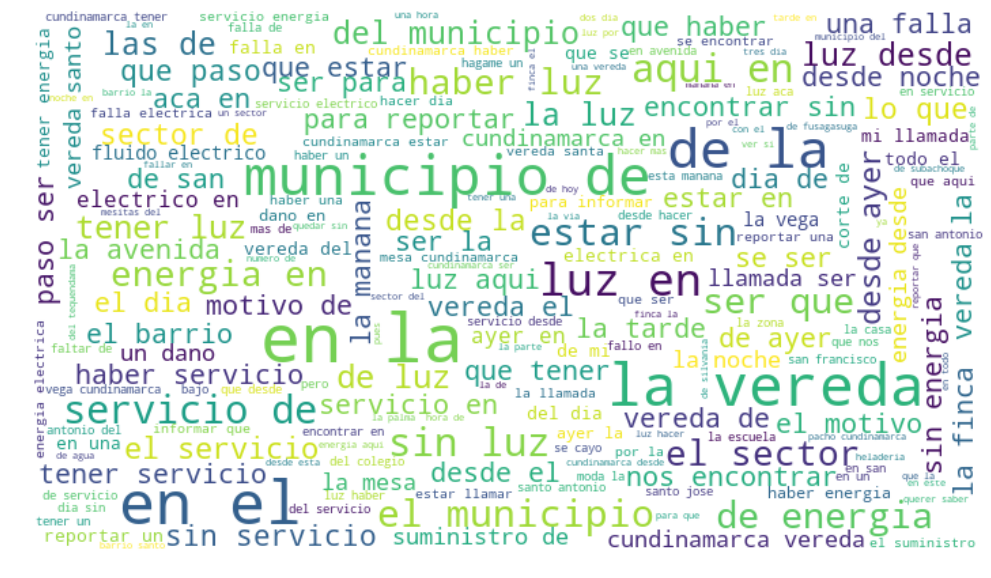

Cluster 12


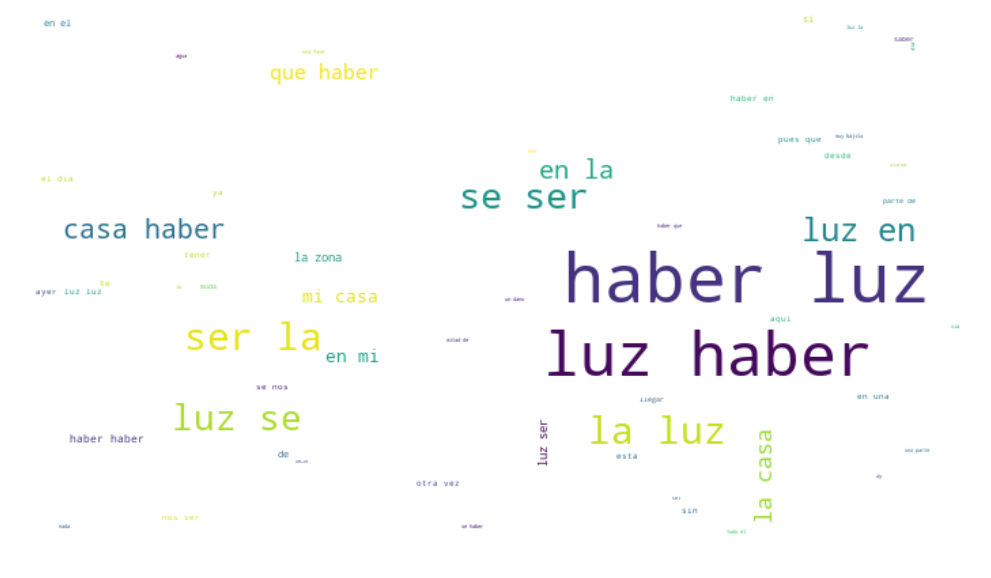

In [78]:
for i in range(cluster_index):
    try:
        print('Cluster {}'.format(i))
        plot_word_cloud(" ".join(review for review in cluster_to_train[cluster_to_train.label == str(i)].iteration.tolist()),i)
    except:
        pass

In [80]:
vocab_per_cluster = pd.DataFrame()
for cluster in range(cluster_index):
    try:
        vocab_per_cluster['Cluster {}: Words'.format(cluster)] = vocabulary(clasifier, str(cluster)).feature.tolist()
        vocab_per_cluster['Cluster {}: Coeffs'.format(cluster)] = vocabulary(clasifier, str(cluster))[str(cluster)].tolist()
    except:
        pass
vocab_per_cluster

Cluster 0: Words  Cluster 0: Coeffs Cluster 1: Words  \
0      reportar            21.59              transformador     
1      reporte             9.67               carrera           
2      reportar un         4.72               barrio            
3      banco               4.63               apartamento       
4      reporte de          4.62               que               
...           ...           ...               ...               
45696  servicio electrico -1.92               manana            
45697  no                 -1.99               ayer              
45698  luz                -2.10               fallo             
45699  estar              -2.57               desde             
45700  electrico          -3.26               servicio          

       Cluster 1: Coeffs Cluster 2: Words  Cluster 2: Coeffs  \
0      8.32               servicio         22.07               
1      6.89               el servicio      5.43                
2      6.84               suministro       4.71                
3      6.72               sin servicio     4.65                
4      5.43               de servicio      4.30                
...     ...                       ...       ...                
45696 -3.29               fallar          -3.19                
45697 -3.34               electrico       -3.93                
45698 -3.42               falla           -4.15                
45699 -4.55               fallo           -4.95                
45700 -7.90               energia         -6.02                

             Cluster 3: Words  Cluster 3: Coeffs Cluster 4: Words  \
0      fallo                   13.17              falla             
1      fallar                  12.57              fallo             
2      falla                   8.94               fallar            
3      corte                   7.35               falla electrica   
4      falla de                6.80               faltar            
...         ...                 ...                  ...            
45696  electricidad           -2.32               corte             
45697  fallo en el suministro -2.33               estar             
45698  de energia             -3.01               reporte           
45699  electrico              -3.06               reportar          
45700  energia                -6.03               servicio          

       Cluster 4: Coeffs Cluster 5: Words  Cluster 5: Coeffs  \
0      9.12               necesitar        9.47                
1      8.35               que              8.07                
2      7.87               porque           7.95                
3      6.24               entonces         7.12                
4      5.82               arreglar         6.50                
...     ...                    ...          ...                
45696 -2.59               electrico       -2.12                
45697 -3.77               dano            -2.29                
45698 -3.88               fallar          -2.41                
45699 -4.01               fallo           -3.01                
45700 -4.41               falla           -3.31                

          Cluster 6: Words  Cluster 6: Coeffs Cluster 7: Words  \
0      energia              18.77              dano              
1      servicio energia     5.25               danos             
2      electricidad         5.14               no                
3      servicio de energia  4.92               ok                
4      tener                4.43               dano en la        
...      ...                 ...                      ...        
45696  dano                -2.80               haber             
45697  fallar              -3.33               servicio          
45698  estar               -3.34               energia           
45699  corte               -4.50               un dano en la     
45700  fallo               -5.44               un dano en        

       Cluster 7: Coeffs Cluster 8: Words  Cluster 8: Coeffs Cluster

In [81]:
vocab_per_cluster[:100]

Cluster 0: Words  Cluster 0: Coeffs      Cluster 1: Words  \
0   reportar                21.59              transformador          
1   reporte                 9.67               carrera                
2   reportar un             4.72               barrio                 
3   banco                   4.63               apartamento            
4   reporte de              4.62               que                    
5   para reportar           4.41               calle                  
6   para                    4.39               los                    
7   reportar una            4.16               presentar              
8   reportar una falla      4.03               numero                 
9   reportar falla          3.54               contador               
10  reportar que            3.34               conjunto               
11  falla                   3.29               donde                  
12  reportar el             2.98               residencial            
13  reporte fallo           2.80               emergencia             
14  hagame un               2.74               un                     
15  reportada               2.72               el transformador       
16  por corte               2.71               edificio               
17  hagame                  2.69               una                    
18  reportar dano           2.67               corriente              
19  reporto                 2.65               se                     
20  un                      2.60               localidad              
21  reportar un dano        2.36               cables                 
22  reportar la             2.24               cuerdas                
23  reportar que no         2.16               corto                  
24  reportaje               2.10               la                     
25  para informar           2.08               presentado             
26  tener alla              2.06               casa                   
27  reportar una falla en   2.06               del                    
28  emergencia              1.93               cable                  
29  reportar fallo          1.88               vivienda               
30  representar             1.87               apartamentos           
31  informar                1.86               el                     
32  reportar faltar         1.81               voltaje                
33  su llamada              1.73               estan                  
34  se ser                  1.71               esta                   
35  tu llamada              1.68               un transformador       
36  ser lo                  1.67               entre                  
37  de una                  1.66               chispas                
38  para reportar el        1.63               clases                 
39  un corte                1.60               intermitencia          
40  reportar fallar         1.59               frente                 
41  reporte de falla        1.56               aqui                   
42  reportar danos          1.55               vivir                  
43  que no                  1.54               el contador            
44  llamada                 1.52               la carrera             
45  reportar que no haber   1.46               cuerda                 
46  reportar falla en       1.45               transformadores        
47  renuncia                1.40               subir                  
48  ah                      1.40               parte                  
49  reportar el dano        1.39               el apartamento         
50  para informar de        1.37               el barrio              
51  reclamo por             1.35               piso                   
52  para reportar que       1.34               poste                  
53  informar de             1.33               direccion              
54  no se ser               1.32               tension                
55  dano de energia         1.28  

In [89]:
# label_test = 1
for label_test in range(cluster_index):
    graph = create_adjacency_graph(data_set = cluster_to_train,
                                   model = clasifier,
                                   label = str(label_test),
                                   num_features = 0,
                                   per_class = True,
                                   levels = 2)
    graph.render('test_render_{}'.format(label_test))